In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd


def randomized_response(p, n, gamma):
    # n people, roughly p cheating, 1 is cheating
    Y = np.random.binomial(1, p, n)
    # 1 is person lies to you with probability 0.5+gamma
    flip = np.random.binomial(1, 0.5-gamma, n)
    Y_flip = abs(flip - Y)
    phat = np.mean((1/(2*gamma))*(Y_flip-0.5+gamma))
    return phat


def randomized_response_laplace(p, n, epsilon):
    X = np.random.binomial(1, p, size=n)
    phat = np.mean(X) + np.random.laplace(0, 1/(epsilon*n))
    return np.round(phat, 4)


print(randomized_response(0.2, 10000, 0.25))
print(randomized_response_laplace(0.2, 10000, 0.25))

0.1914
0.1974


In [245]:
np.round(np.array([-1.2345, 2.3456, -3.4567, 4.5678])).clip(0)

array([0., 2., 0., 5.])

In [390]:
data = pd.DataFrame({
    'age': ['18-24', '18-24', '25-34', '25-34', '35-44', '35-44', '45+', '45+'],
    'gender': ['female', 'male', 'female', 'male', 'female', 'male', 'female', 'male'],
    'people': [1021, 812, 906, 951, 105, 120, 10, 2]
})


def add_laplace_noise(data, epsilon):
    data['noised_people'] = data['people'] + np.random.laplace(0, 2/epsilon, len(data['people']))
    data['rounded_noised_people'] = np.round(data['noised_people'])
    return data

In [422]:
def mean_absolute_error(data):
    # MAE between data[‘noised_people’] and data[‘people’]
    mae = np.mean(np.abs(data['noised_people']-data['people']))
    # MAE between data[‘rounded_noised_people’] and data[‘people’]
    rounded_mae = np.mean(
        np.abs(np.round(data['noised_people']).clip(0)-data['people']))
    return {'mae': mae, 'rounded_mae': rounded_mae}


def run_simulation(data, epsilon=1, K=1000, flag=True):
    maes = {'mae': [], 'rounded_mae': []}
    binned = {'mae': [], 'rounded_mae': []}
    for _ in range(K):
        noised_data = add_laplace_noise(data, epsilon)
        mae = mean_absolute_error(noised_data)
        noised_data_male_45plus = noised_data.query(
            'age==\'45+\' & gender==\'male\'')
        mae_male_45plus = mean_absolute_error(noised_data_male_45plus)
        for key in maes.keys():
            maes[key].append(mae[key])
            binned[key].append(mae_male_45plus[key])
    for metric in ['mae', 'rounded_mae']:
        fig, axs = plt.subplots(1, 2, figsize=(
            10, 4), sharex=True, sharey=True)
        fig.suptitle('Mean Absolute Error ' +
                     metric.removesuffix('mae').replace('_', ' ') + f'Eps={epsilon}')
        axs[0].hist(maes[metric], color='gray', density=True, bins=20)
        kde = gaussian_kde(maes[metric])
        x = np.linspace(min(maes[metric]), max(maes[metric]), 100)
        axs[0].plot(x, kde(x), color='red')
        axs[0].set_title('all')
        if(flag):
            axs[0].set_xlim([0,15])
            axs[0].set_ylim([0,0.8])
        axs[1].hist(binned[metric], color='gray', density=True, bins=20)
        kde = gaussian_kde(binned[metric])
        x = np.linspace(min(binned[metric]), max(binned[metric]), 100)
        axs[1].plot(x, kde(x), color='red')
        axs[1].set_title('(male, 45+)')
    plt.show()

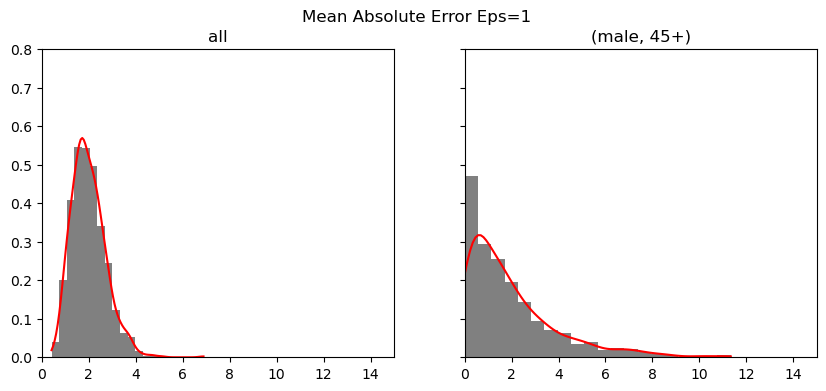

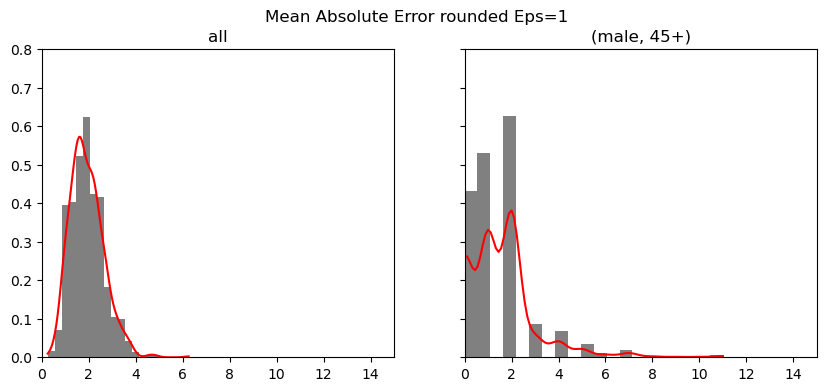

In [423]:
run_simulation(data)

## Comments:
While the mean absolute errors are close enough together that its hard to tell them apart, the rounded MAE's are more obviously different which leads me to conclude that in the nonrounded MAE's, the values may be in the same bin but on either side of the 0.5 which should infer that there is uncertainty within our values which I would assume means good for privacy and still useful.

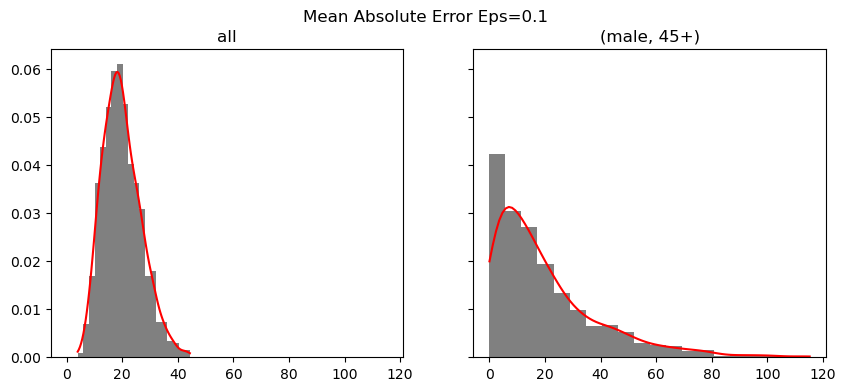

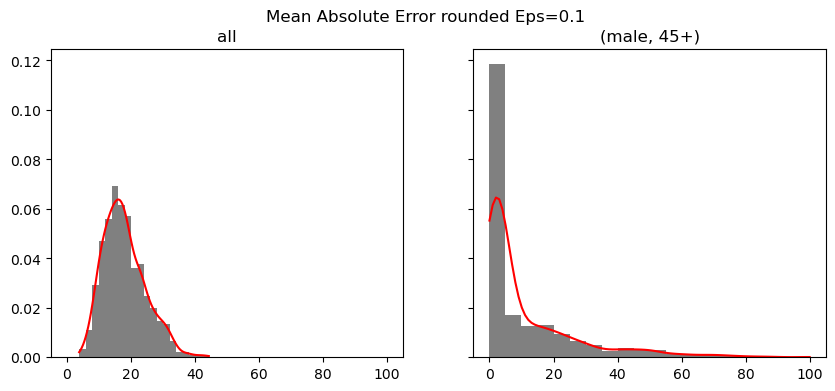

In [424]:
run_simulation(data, epsilon=0.1, flag=False)

# Comments:
The difference in epsilon appears to have increased the variance a lot more. There overall less values in each bin and the largest bin increased from about 17.5 to about 100. This is expected because lowering epsilon should provide more privacy.

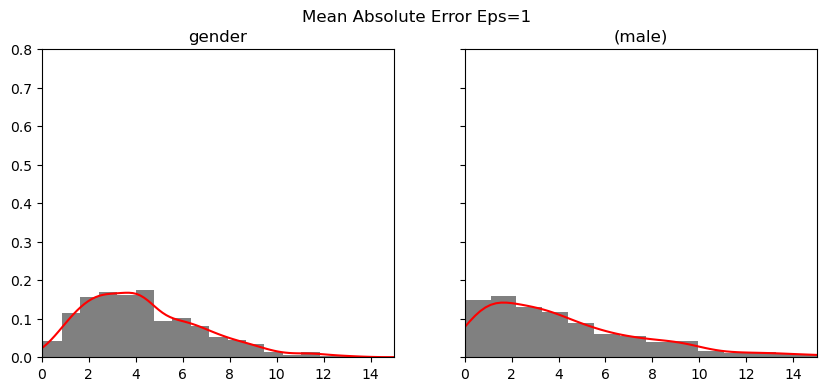

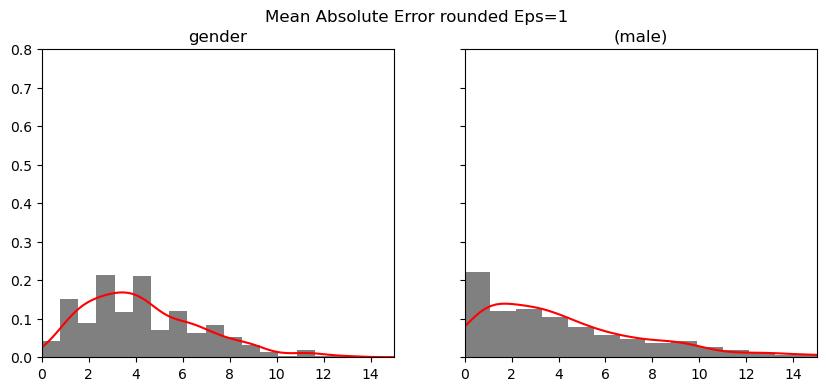

In [418]:
epsilon = 1
K = 1000
maes = {'mae': [], 'rounded_mae': []}
binned = {'mae': [], 'rounded_mae': []}
for _ in range(K):
    noised_data = add_laplace_noise(data, epsilon)
    noised_data_gender = noised_data.drop(columns='age').groupby(
        'gender').agg(lambda x: sum(x)).reset_index()
    mae_gender = mean_absolute_error(noised_data_gender)
    noised_data_male = noised_data_gender.query('gender==\'male\'')
    mae_male = mean_absolute_error(noised_data_male)
    for key in maes.keys():
        maes[key].append(mae_gender[key])
        binned[key].append(mae_male[key])
for metric in ['mae', 'rounded_mae']:
    fig, axs = plt.subplots(1, 2, figsize=(
        10, 4), sharex=True, sharey=True)
    fig.suptitle('Mean Absolute Error ' +
                 metric.removesuffix('mae').replace('_', ' ') + f'Eps={epsilon}')
    axs[0].hist(maes[metric], color='gray', density=True, bins=20)
    kde = gaussian_kde(maes[metric])
    x = np.linspace(min(maes[metric]), max(maes[metric]), 100)
    axs[0].plot(x, kde(x), color='red')
    axs[0].set_title('gender')
    axs[0].set_xlim([0,15])
    axs[0].set_ylim([0,0.8])
    axs[1].hist(binned[metric], color='gray', density=True, bins=20)
    kde = gaussian_kde(binned[metric])
    x = np.linspace(min(binned[metric]), max(binned[metric]), 100)
    axs[1].plot(x, kde(x), color='red')
    axs[1].set_title('(male)')
plt.show()

# Comments:
With respect to the first two histogram collections, this collection seems like an inbetween version of the two.
These histograms most resemble the first histogram collection since most of the values are centered around a single digit number so I would think this is slightly more private than normally having an epsilon of 1